In [1]:
# import

import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import numpy as np
import requests
from io import BytesIO
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
# print(tfds.list_builders())
# # print(tf.__version__)

# import warnings
# warnings.filterwarnings("ignore")

# print("완료!")
print(f"TensorFlow Datasets 버전: {tfds.__version__}")
# plant_village가 없는 버전도 있음

TensorFlow Datasets 버전: 4.4.0


In [3]:
!mkdir -p ~/aiffel/plants/PlantImages
!ln -s ~/data/* ~/aiffel/plants/

ln: failed to create symbolic link '/aiffel/aiffel/plants/cat_face.jpg': File exists
ln: failed to create symbolic link '/aiffel/aiffel/plants/cats_vs_dogs': File exists
ln: failed to create symbolic link '/aiffel/aiffel/plants/my_cat.jpg': File exists
ln: failed to create symbolic link '/aiffel/aiffel/plants/my_dog.jpg': File exists


In [4]:
# 데이터 분할
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='plant_village',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/plant_village/dataset',
    download=True,
    with_info=True,
    as_supervised=True,
)

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

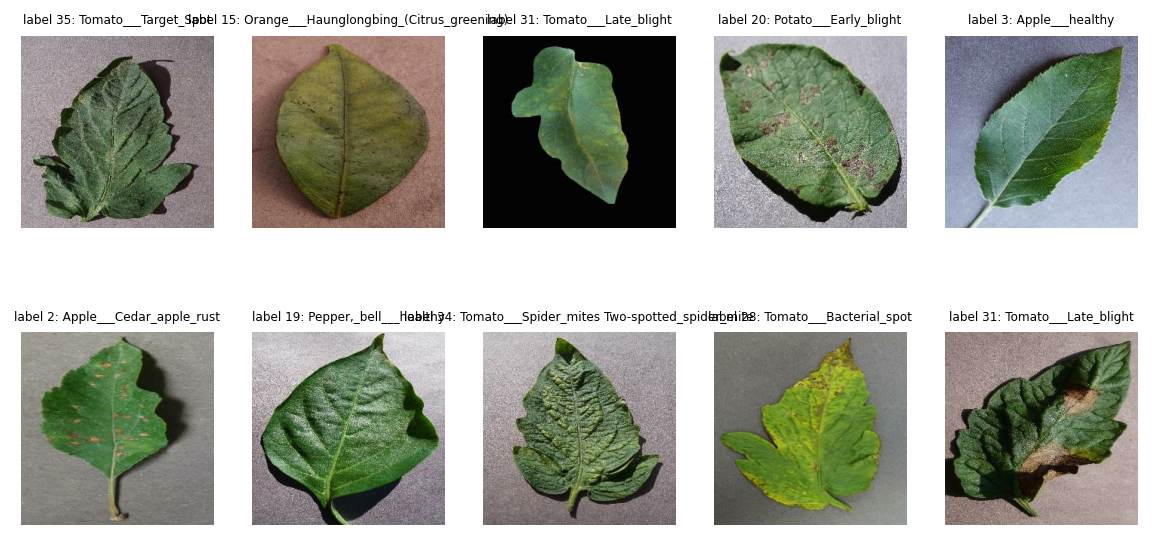

In [7]:
# tfds 코드로 직접 다운로드 받을 경우 metadata를 같이 가져옴
# 로컬 디렉토리에 zip 파일 직접 다운로드 및 압축해제 시 클래스명을 별도로 지정해줘야 함
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}', fontsize = 6)
    plt.axis('off')

In [8]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


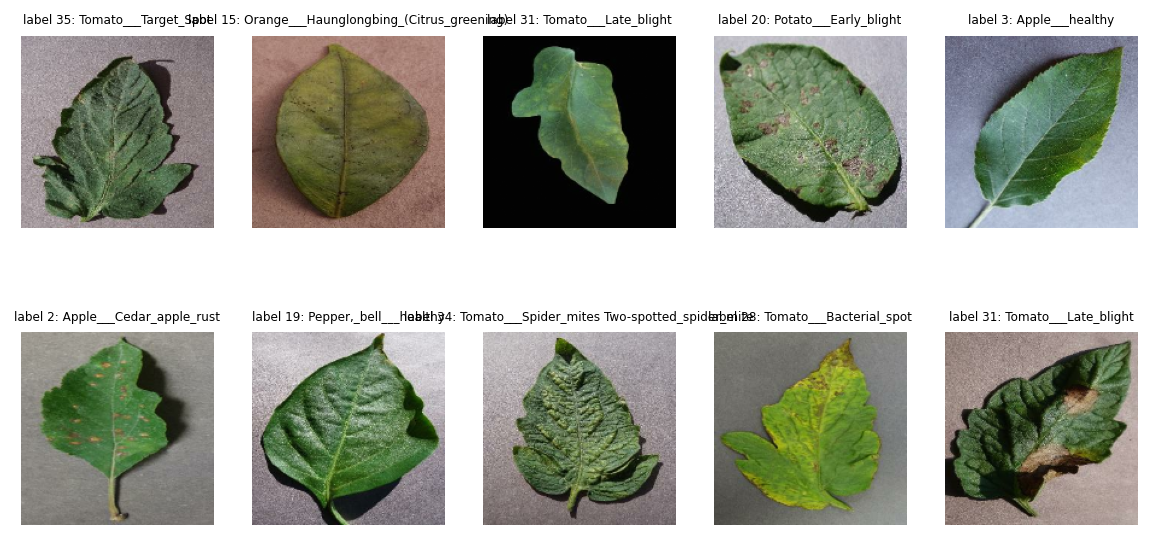

In [10]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}', fontsize = 6)
    plt.axis('off')

In [11]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=38, activation='softmax')
])
# Plant 클래스 총 개수 = 38개
# 폴더를 직접 열어보면 plant가 아닌

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

In [13]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])


# 다중분류 문제이기 때문에 sparse_categorical_crossentropy 사용함
# learning_rate를 0.0001로 시작해 조금씩 변경해보려 했으나 첫 시도에 높은 정확도가 출력되어 변경하지 않음

In [14]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [15]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [16]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [17]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
# 훈련 전

20/20 [==============================] - 24s 21ms/step - loss: 3.6257 - accuracy: 0.0250
initial loss: 3.63
initial accuracy: 0.03


In [18]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
1358/1358 [==============================] - 54s 37ms/step - loss: 1.0428 - accuracy: 0.7006 - val_loss: 0.6671 - val_accuracy: 0.7995
Epoch 2/10
1358/1358 [==============================] - 45s 33ms/step - loss: 0.4484 - accuracy: 0.8644 - val_loss: 0.4204 - val_accuracy: 0.8739
Epoch 3/10
1358/1358 [==============================] - 45s 33ms/step - loss: 0.2823 - accuracy: 0.9146 - val_loss: 0.3170 - val_accuracy: 0.9039
Epoch 4/10
1358/1358 [==============================] - 45s 33ms/step - loss: 0.1857 - accuracy: 0.9451 - val_loss: 0.2888 - val_accuracy: 0.9133
Epoch 5/10
1358/1358 [==============================] - 45s 33ms/step - loss: 0.1283 - accuracy: 0.9617 - val_loss: 0.2623 - val_accuracy: 0.9241
Epoch 6/10
1358/1358 [==============================] - 46s 33ms/step - loss: 0.0861 - accuracy: 0.9744 - val_loss: 0.3349 - val_accuracy: 0.9033
Epoch 7/10
1358/1358 [==============================] - 47s 34ms/step - loss: 0.0589 - accuracy: 0.9830 - val_loss: 0.2444 -

In [19]:
# 모델 저장

model.save('plant1Qreal.h5')

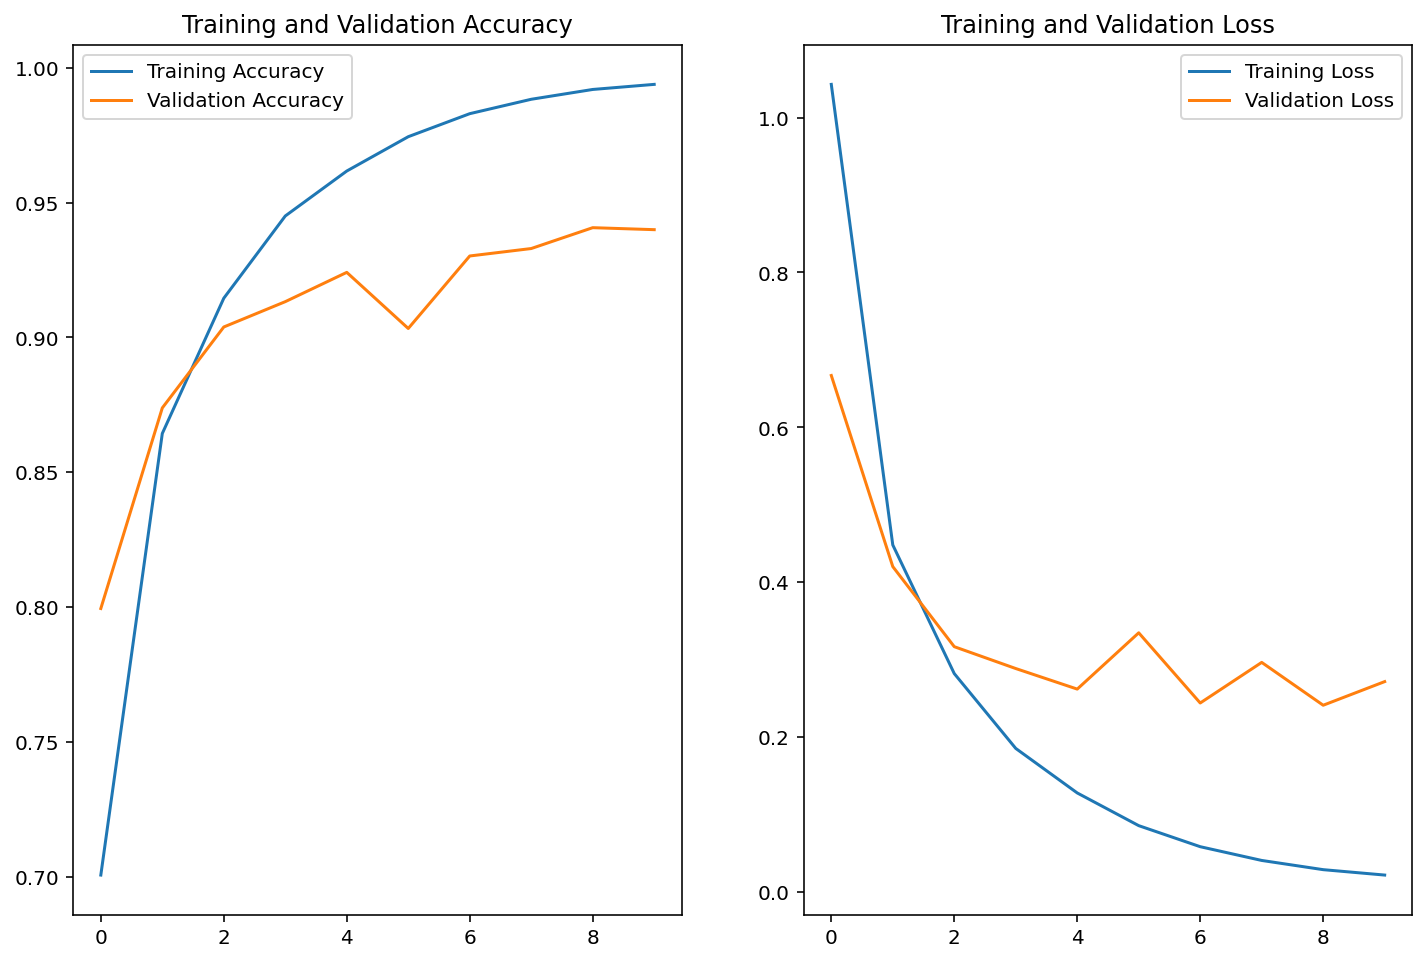

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [21]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions

array([[1.0074418e-01, 3.0994581e-02, 8.1938092e-23, ..., 4.4334857e-04,
        2.1278051e-05, 5.2134946e-10],
       [8.8959229e-07, 5.0917857e-15, 1.5065321e-09, ..., 1.9352829e-08,
        3.2159728e-21, 1.5010538e-13],
       [4.6781235e-36, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.4451628e-21],
       ...,
       [4.1837475e-17, 3.0481190e-28, 6.2053905e-13, ..., 5.1599437e-29,
        2.3327100e-35, 3.1613216e-03],
       [1.9643305e-38, 0.0000000e+00, 9.6625148e-36, ..., 0.0000000e+00,
        0.0000000e+00, 5.8689850e-19],
       [3.6131773e-06, 1.3784134e-17, 1.7016586e-25, ..., 1.8888014e-11,
        3.4200809e-14, 1.6891637e-17]], dtype=float32)

In [22]:
predictions = np.argmax(predictions, axis=1)
predictions

array([ 3, 22,  9, 37, 35, 15, 16, 19, 16, 20, 15, 28, 25, 33,  8, 15, 28,
       34, 30, 35, 15, 29, 34,  3, 25, 15, 11, 24, 37, 28,  9,  3])

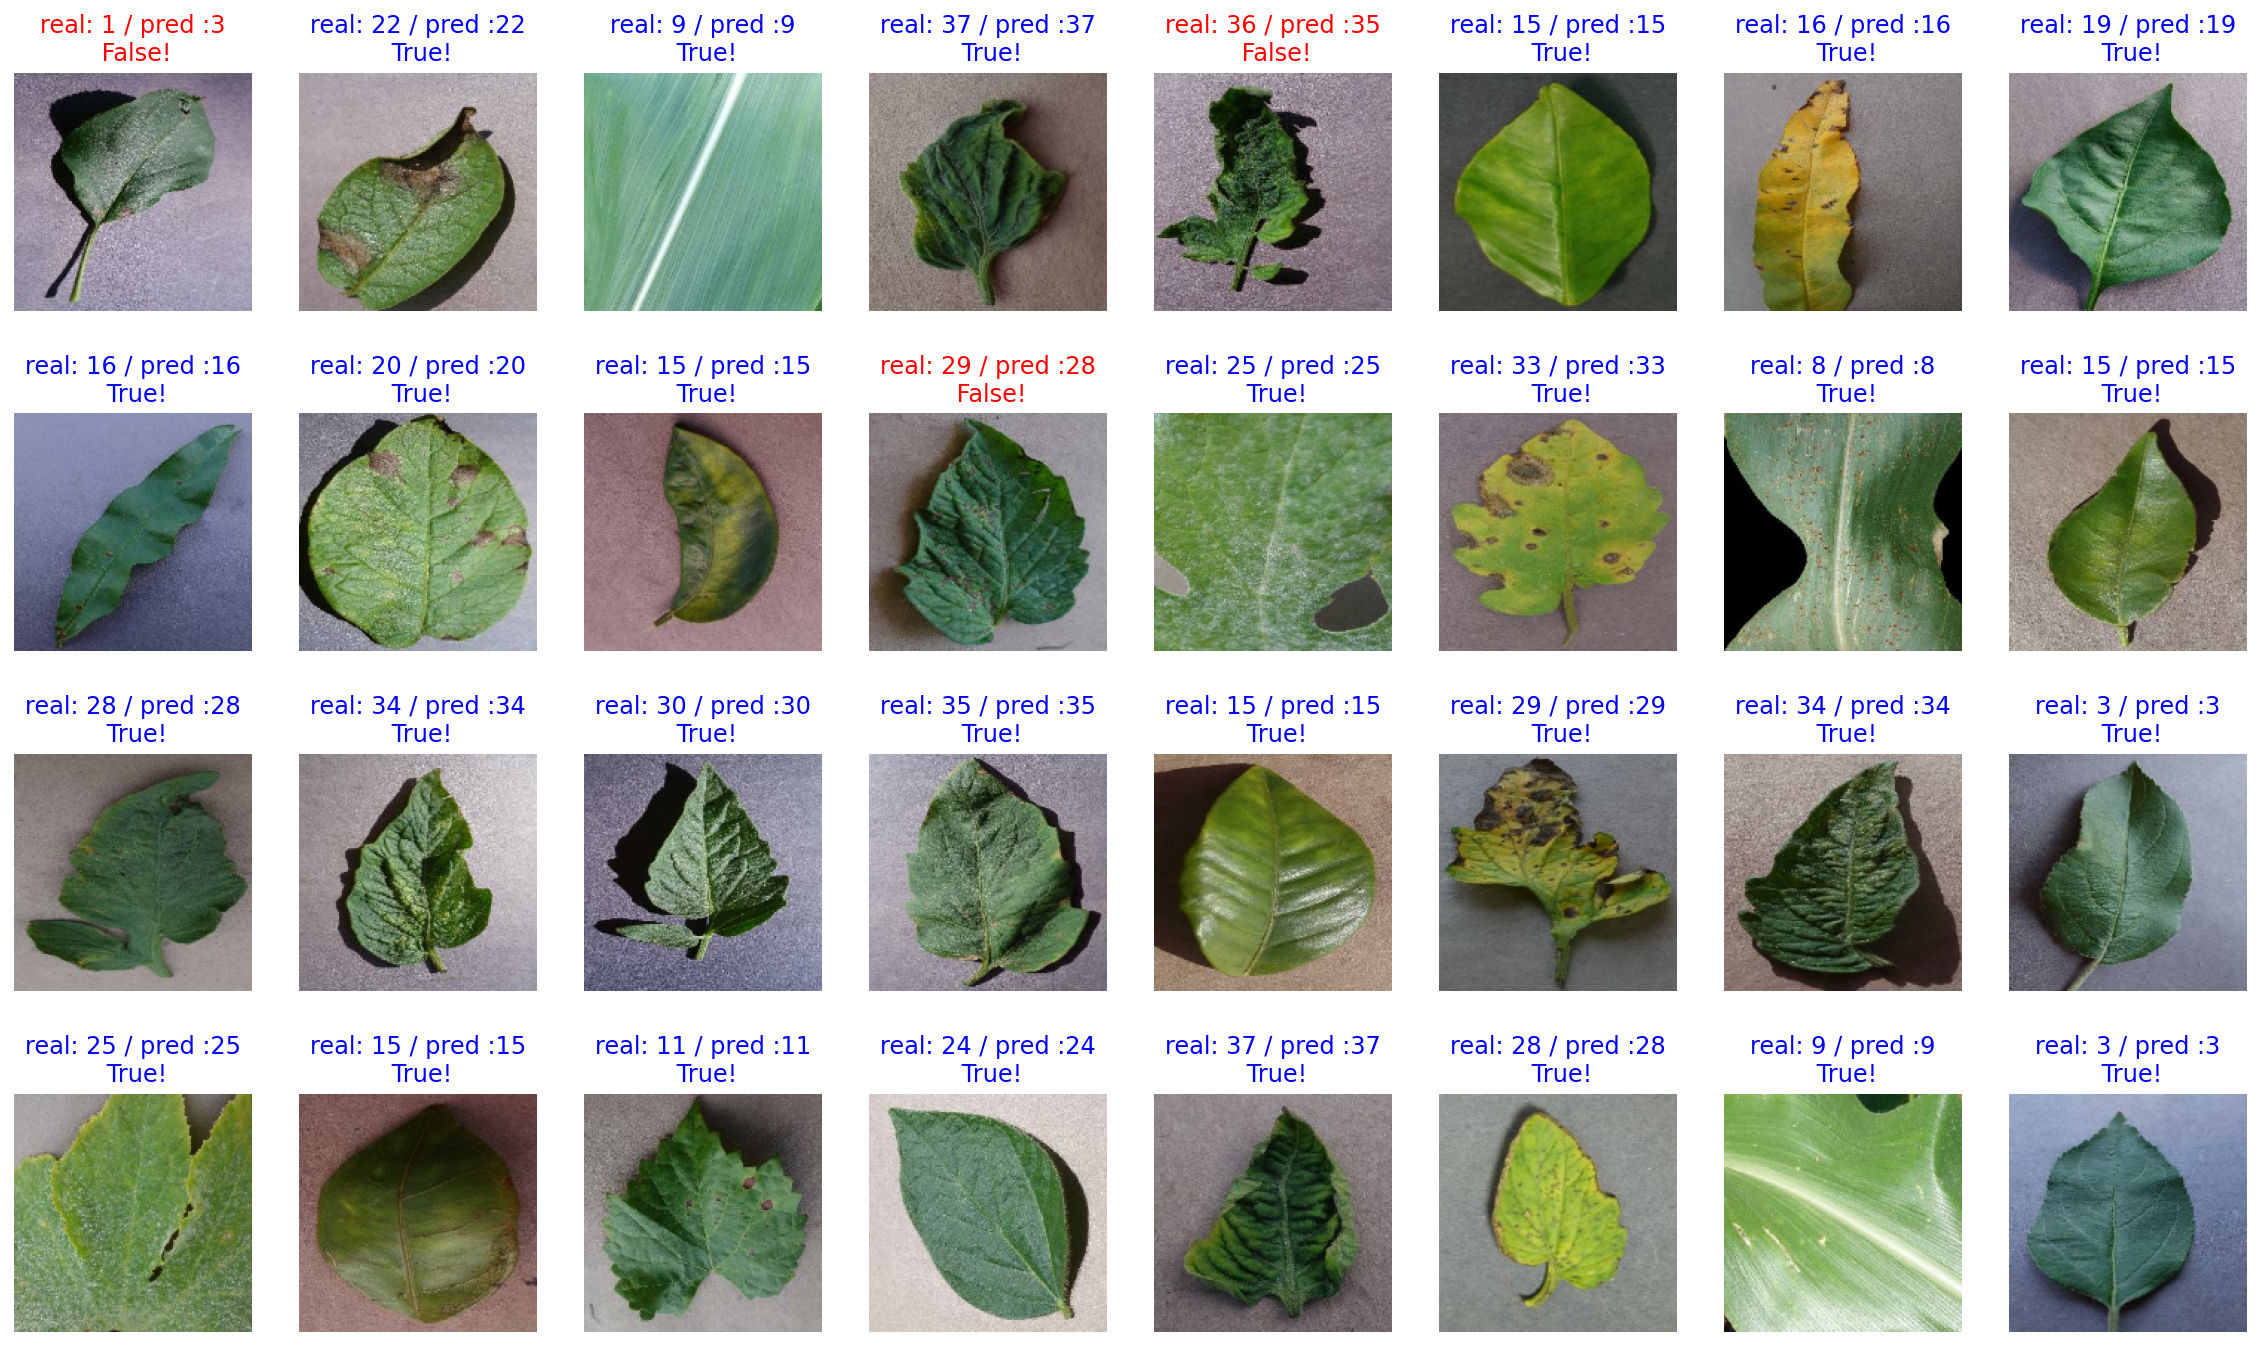

In [23]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [24]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    if label == prediction:
        count += 1


print(count / 32 * 100)

90.625


In [25]:
# IMG_SIZE = 160
# img_dir_path = os.getenv("HOME") + "/aiffel/workspace/leaves"
# sample_image_path = os.path.join(img_dir_path, 'F09.jpg')

# sample_image = load_img(sample_image_path, target_size=(IMG_SIZE, IMG_SIZE))
# sample_image

In [26]:
# sample_image = img_to_array(sample_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
# sample_image.shape

In [27]:
# prediction = model.predict(sample_image)
# prediction

In [28]:
# predicted_class_index = np.argmax(prediction[0])
# print(f"예측된 클래스 인덱스: {predicted_class_index}")

In [29]:
class_names = metadata.features['label'].names

In [30]:
# def local_image(dirpath, filename, img_size=160):
#     filepath = os.path.join(dirpath, filename)
#     image = load_img(filepath, target_size=(img_size, img_size))
#     plt.imshow(image)
#     plt.axis('off')
#     image = img_to_array(image).reshape(1, img_size, img_size, 3)
    
#     # 예측 수행
#     prediction = model.predict(image)[0]
    
#     # 가장 높은 확률을 가진 클래스 찾기
#     predicted_class_index = np.argmax(prediction)
#     predicted_class_name = class_names[predicted_class_index]
#     confidence = prediction[predicted_class_index] * 100
    
#     print(f"이 이미지는 {predicted_class_name}일 확률이 {confidence:.1f}%입니다.")

# filename = 'TomatoGomPangYee.jpg'

# local_image(img_dir_path, filename)

In [32]:
def online_image(image_source, img_size=160, is_url=False):

    if is_url:
        # URL에서 이미지 로드
        response = requests.get(image_source)
        image = Image.open(BytesIO(response.content))
        image = image.resize((img_size, img_size))
    else:
        print('사용할 수 없는 링크입니다.')
    
    # 이미지 표시
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    # 이미지를 모델에 적합한 형태로 변환
    if isinstance(image, Image.Image):
        image_array = img_to_array(image)
    else:
        image_array = img_to_array(image)
    
    image_array = image_array.reshape(1, img_size, img_size, 3)
    
    # 예측 수행
    prediction = model.predict(image_array)[0]
    
    # 가장 높은 확률을 가진 클래스 찾기
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = prediction[predicted_class_index] * 100
    
    print(f"이 이미지는 {predicted_class_name}일 확률이 {confidence:.1f}%입니다.")

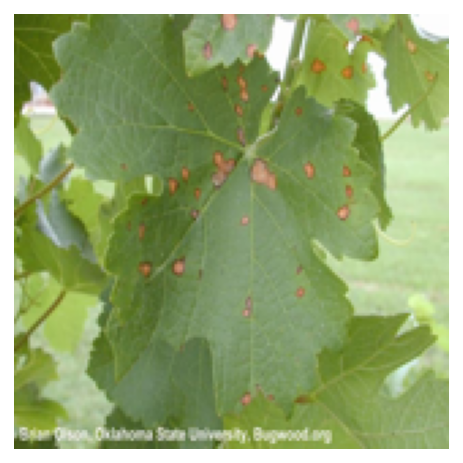

이 이미지는 Soybean___healthy일 확률이 100.0%입니다.


In [33]:
# 이미지 링크를 할당하고 함수 실행

image_url = "https://content.peat-cloud.com/w800/black-rot-of-grape-grape-1575457334.jpg"

online_image(image_url, is_url=True)

In [34]:
print(len(train_batches))
print(len(validation_batches))
print(len(test_batches))

1358
170
170


In [35]:
# 테스트 데이터셋 prediction

steps = len(test_batches)

Y_pred = []
Y_true = []


for x, y in test_batches:
    y_pred = model.predict(x)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y, axis=1) if len(y.shape) > 1 else y
    
    Y_pred.extend(y_pred_classes)
    Y_true.extend(y_true_classes)

Y_pred = np.array(Y_pred)
Y_true = np.array(Y_true)

# 전체 정확도 계산 및 출력
accuracy = np.mean(Y_pred == Y_true)
print(f"테스트 데이터셋 정확도: {accuracy:.4f}")

테스트 데이터셋 정확도: 0.9403



Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.81      0.86      0.83        58
                            Apple___Black_rot       0.98      0.89      0.94        65
                     Apple___Cedar_apple_rust       0.95      0.72      0.82        25
                              Apple___healthy       0.95      0.89      0.92       159
                          Blueberry___healthy       0.96      0.97      0.97       133
                             Cherry___healthy       0.94      0.99      0.96        90
                      Cherry___Powdery_mildew       0.97      0.96      0.96       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.55      0.68        56
                           Corn___Common_rust       0.99      0.98      0.98       127
                               Corn___healthy       1.00      1.00      1.00       112
                  

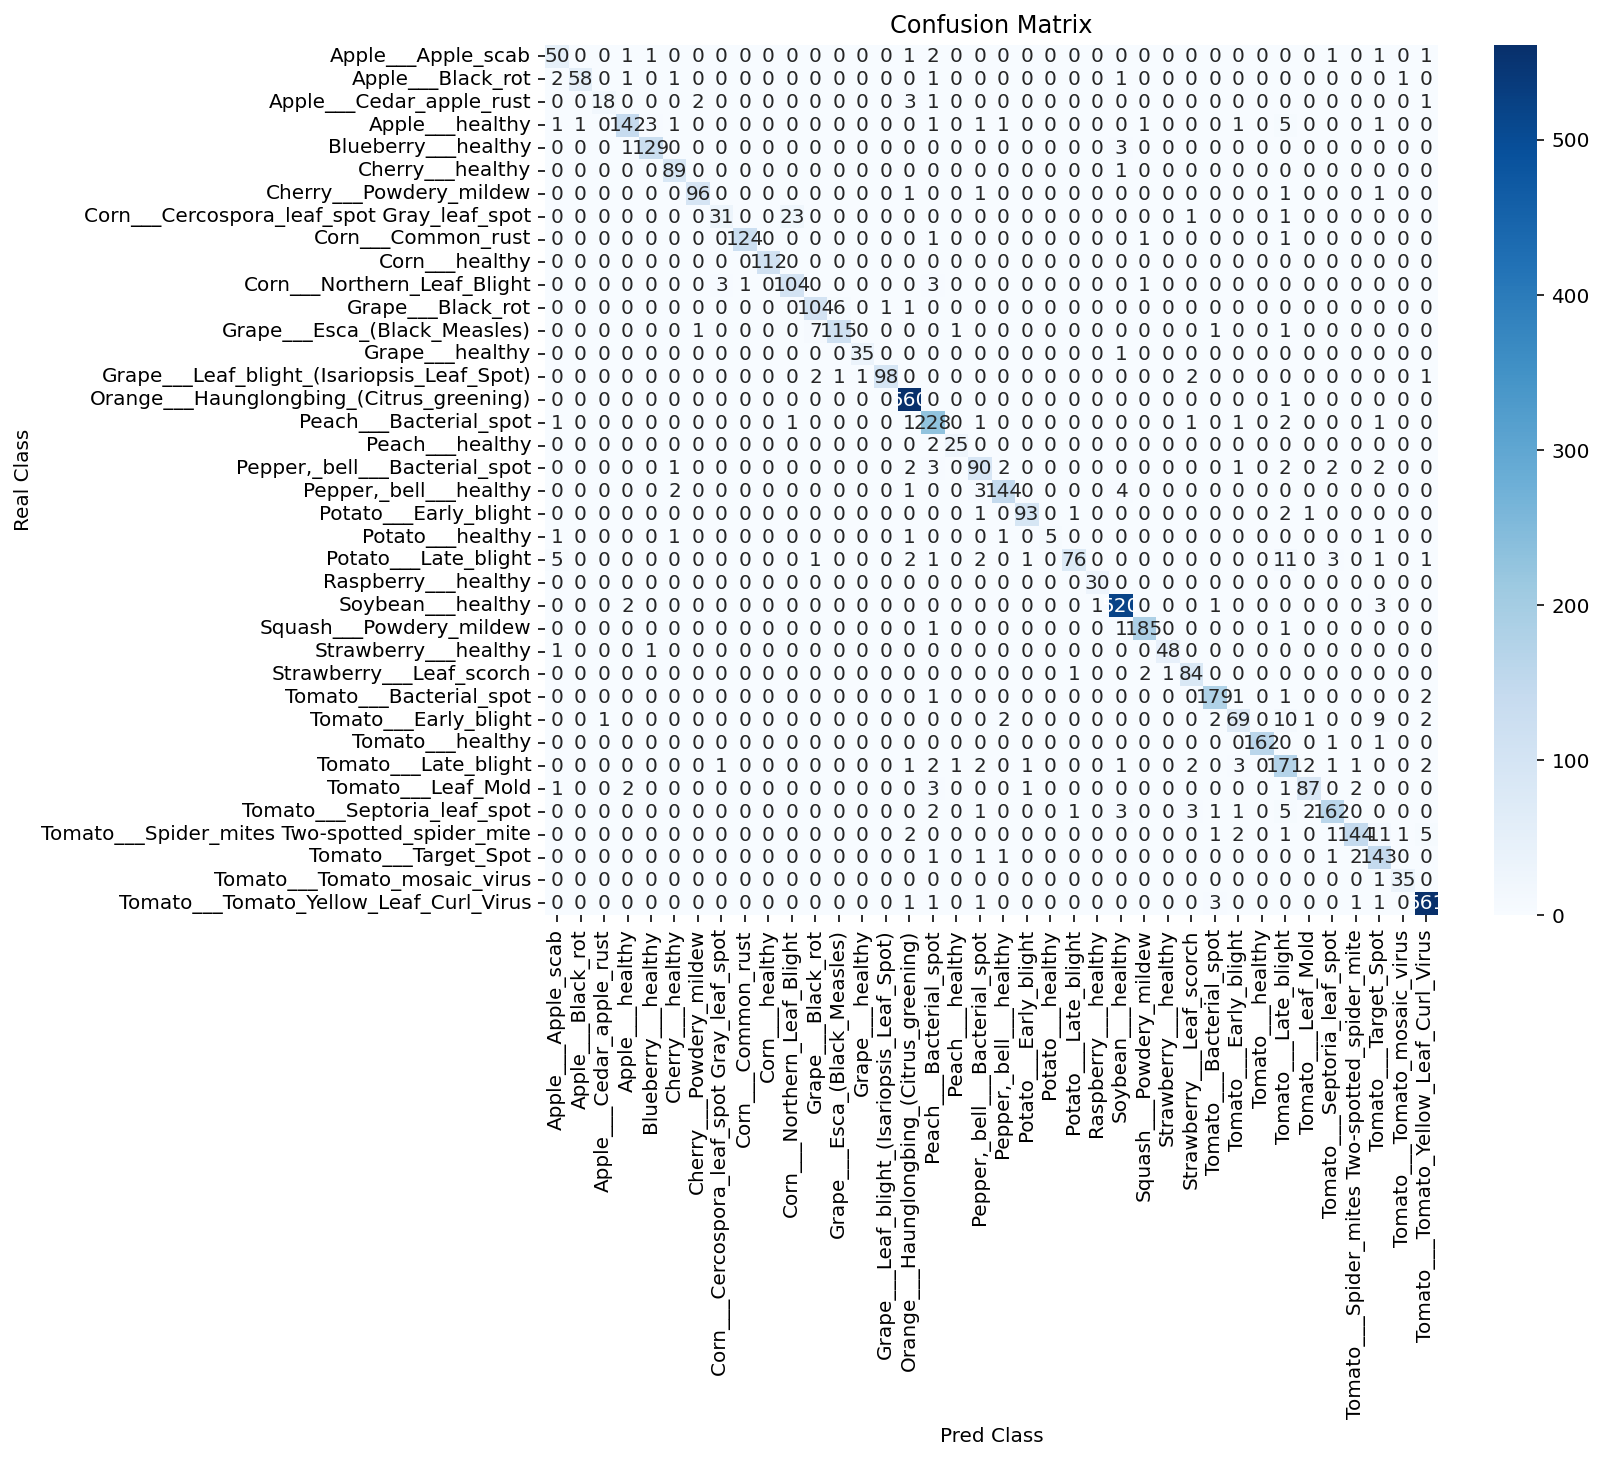

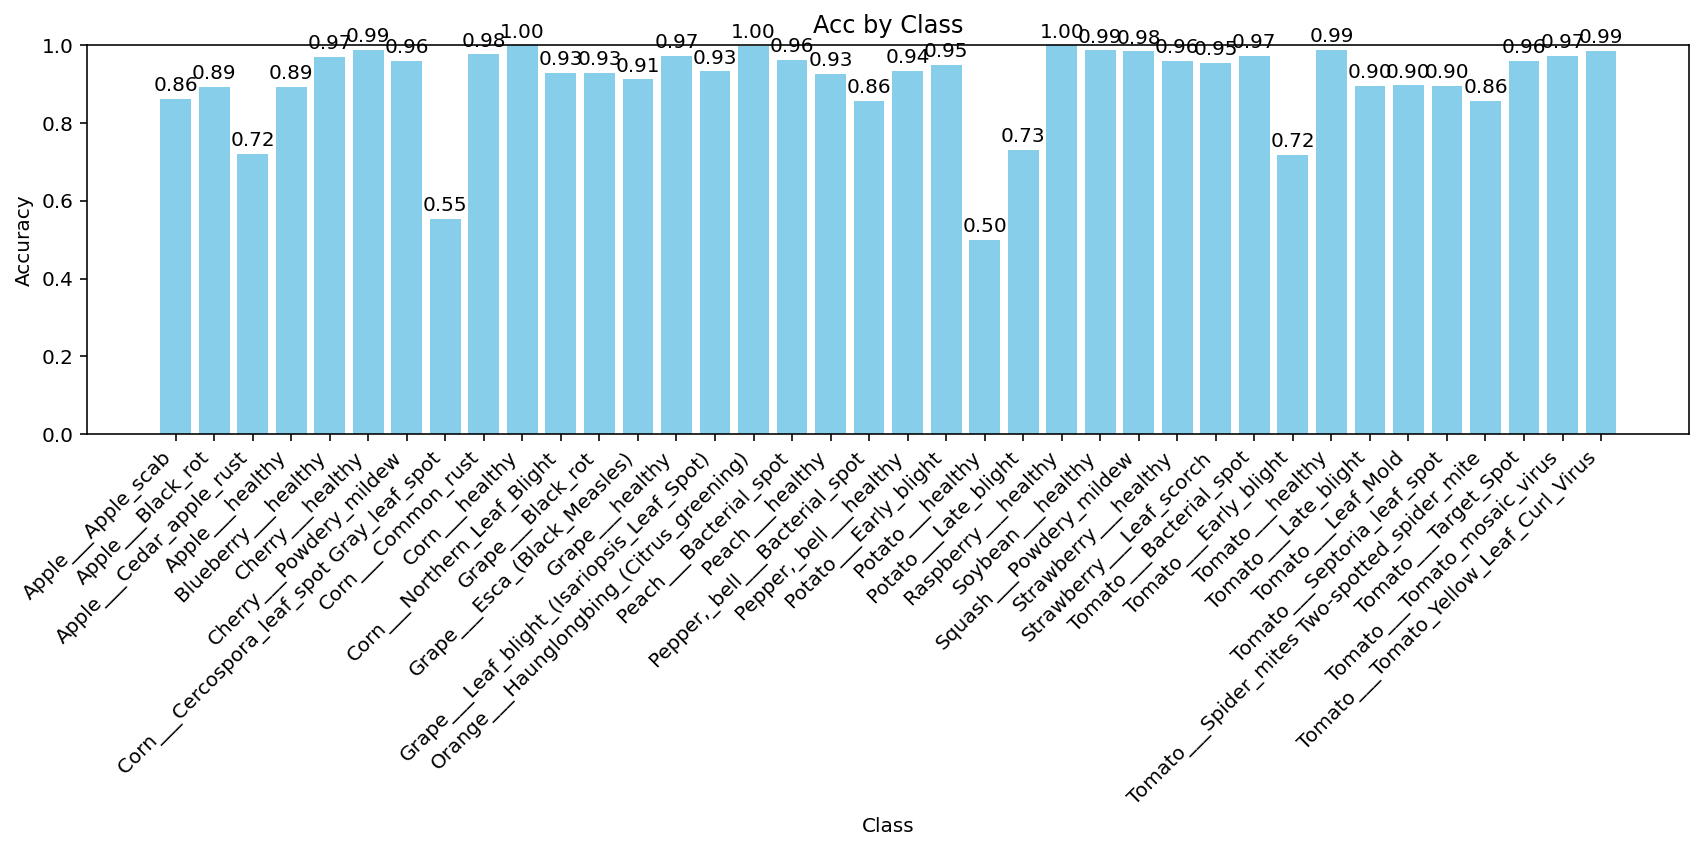

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 분류 리포트 출력
print("\nClassification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_names))

# 혼동 행렬(Confusion Matrix) 시각화
plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y_true, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Pred Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix')
plt.show()

# 클래스별 정확도 시각화
class_accuracies = []
for i in range(len(class_names)):
    idx = np.where(Y_true == i)[0]
    class_acc = np.sum(Y_pred[idx] == Y_true[idx]) / len(idx) if len(idx) > 0 else 0
    class_accuracies.append(class_acc)

plt.figure(figsize=(12, 6))
plt.bar(class_names, class_accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Acc by Class')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
for i, acc in enumerate(class_accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center')
plt.tight_layout()
plt.show()




오분류 샘플 수: 324


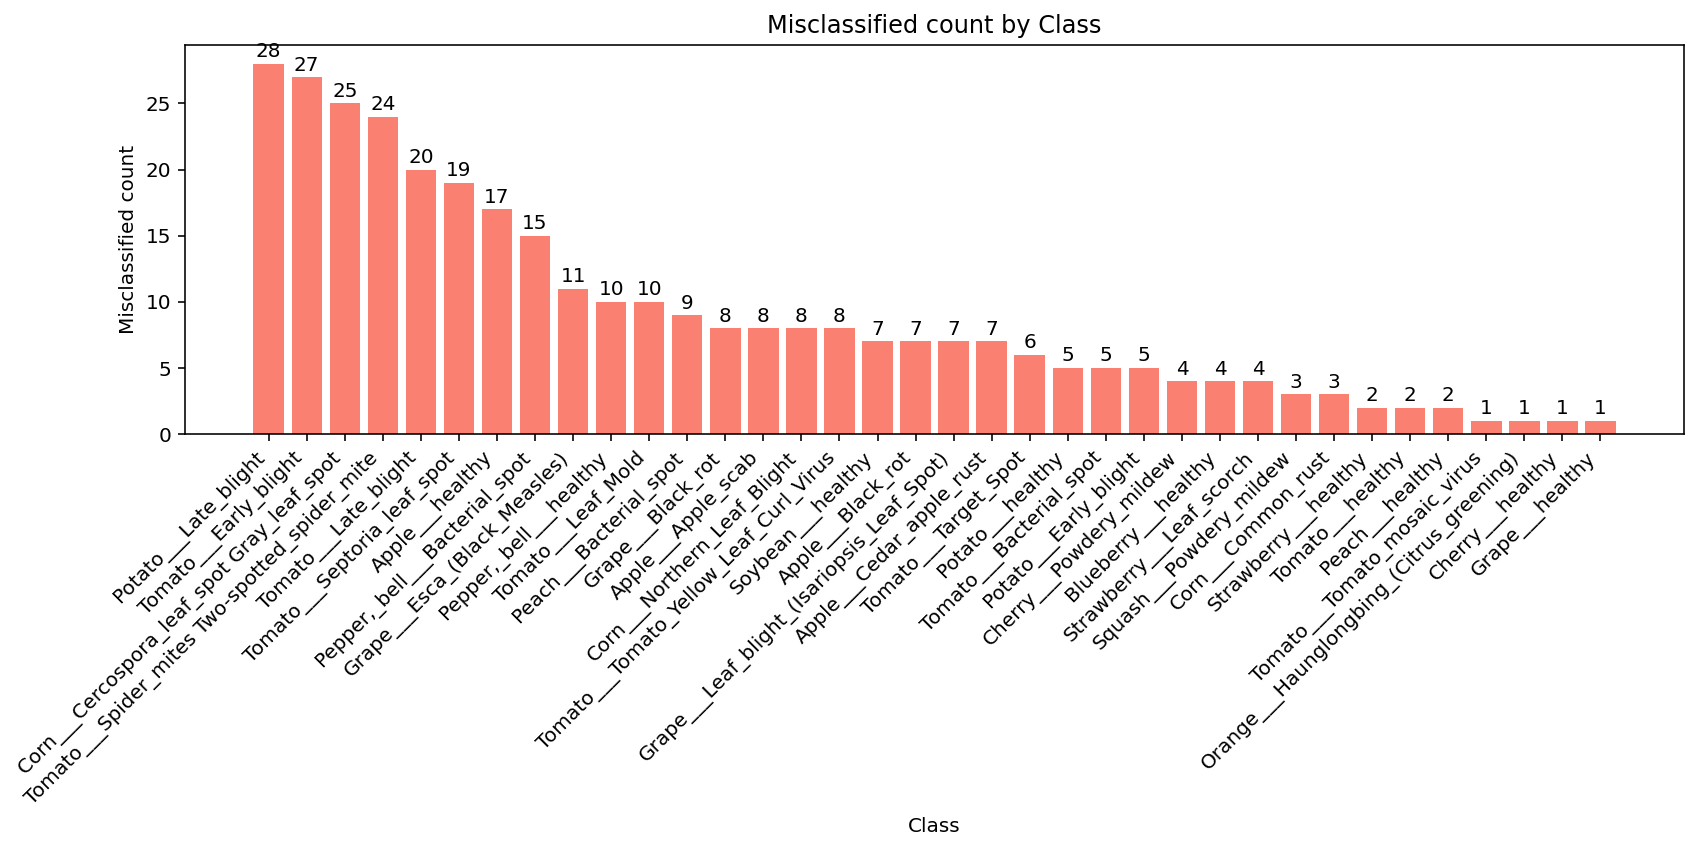

In [40]:
# 오분류 샘플 시각화
misclassified_indices = np.where(Y_pred != Y_true)[0]

if len(misclassified_indices) > 0:
    print(f"\n오분류 샘플 수: {len(misclassified_indices)}")
    
    # 오분류 분석을 위한 데이터 수집
    misclass_data = []
    for idx in misclassified_indices:
        true_class = class_names[Y_true[idx]]
        pred_class = class_names[Y_pred[idx]]
        misclass_data.append((true_class, pred_class))
    
    # 클래스별 오분류 횟수 계산
    from collections import Counter
    class_error_counts = Counter([true_class for true_class, _ in misclass_data])
    
    # 막대 그래프 생성
    plt.figure(figsize=(12, 6))
    classes = list(class_error_counts.keys())
    counts = list(class_error_counts.values())
    
    # 정렬 (선택사항)
    sorted_indices = np.argsort(counts)[::-1]  # 내림차순 정렬
    sorted_classes = [classes[i] for i in sorted_indices]
    sorted_counts = [counts[i] for i in sorted_indices]
    
    plt.bar(sorted_classes, sorted_counts, color='salmon')
    plt.xlabel('Class')
    plt.ylabel('Misclassified count')
    plt.title('Misclassified count by Class')
    plt.xticks(rotation=45, ha='right')
    
    # 값 표시
    for i, count in enumerate(sorted_counts):
        plt.text(i, count + 0.5, str(count), ha='center')
        
    plt.tight_layout()
    plt.show()
    
    # 추가: 오분류 패턴 시각화 (어떤 클래스가 어떤 클래스로 잘못 예측되는지)
    from collections import defaultdict
    misclass_patterns = defaultdict(Counter)
    
    for true_class, pred_class in misclass_data:
        misclass_patterns[true_class][pred_class] += 1